In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from random import choice
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from skimage.transform import resize
from scipy.stats import norm
import tensorflow as tf
import sys
sys.path.append('..')
from utils import *
from vae_data_generator import DataGenerator

In [2]:
base_dir      = '../data/clr_120_160/'
image_dir     = base_dir + 'images/'
anno_dir      = base_dir + 'annotations/'
train_path = '../data/evened_train.txt'
test_path  = '../data/evened_test.txt'

raw_train = load_dataset(train_path)
raw_test = load_dataset(test_path)


In [3]:
train_gen=DataGenerator(batch_size=50, 
                      data_set=raw_train[:100],
                      image_dir=image_dir)

test_gen=DataGenerator(batch_size=50, 
                      data_set=raw_test[:50],
                      image_dir=image_dir)

sample_gen=DataGenerator(batch_size=10, 
                      data_set=raw_test[:10],
                      image_dir=image_dir,
                      shuffle=False)

Loading Data: 100%|██████████| 10/10 [00:00<00:00, 622.57it/s]


0.0
0.9411764705882353
0.0
0.7764705882352941


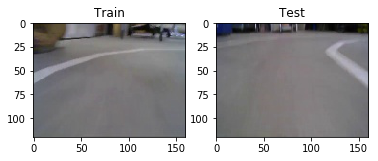

In [4]:
%matplotlib inline
train_ims, _, _ = train_gen.get_next_batch()
test_ims, _, _ = test_gen.get_next_batch()

idx=0
plt.subplot(121)
plt.imshow(train_ims[idx])
fig = plt.gcf()
plt.title("Train")
print(np.min(train_ims[idx]))
print(np.max(train_ims[idx]))

plt.subplot(122)
plt.imshow(test_ims[idx])
fig = plt.gcf()
plt.title("Test")
print(np.min(test_ims[idx]))
print(np.max(test_ims[idx]))
train_gen.reset()
test_gen.reset()

In [5]:
from vae import Model
#from autoencoder import Model
classes = [x for x in range(15)]
feature_extractor = Model([120,160,3])

INFO:tensorflow:Restoring parameters from vae_no_activation_func_000/ep_13_loss_11.624.ckpt


Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 5.664409160614014


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Test Loss: 4.282
--------------------------------------------------
Model saved at vae_no_activation_sigmod_recon_not_zero_centered/ep_1_loss_4.282.ckpt


Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 4.300649642944336


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Test Loss: 4.020
--------------------------------------------------
Model saved at vae_no_activation_sigmod_recon_not_zero_centered/ep_2_loss_4.020.ckpt
Done, final best loss: 4.020


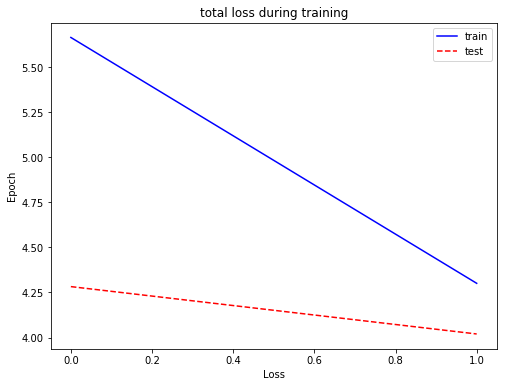

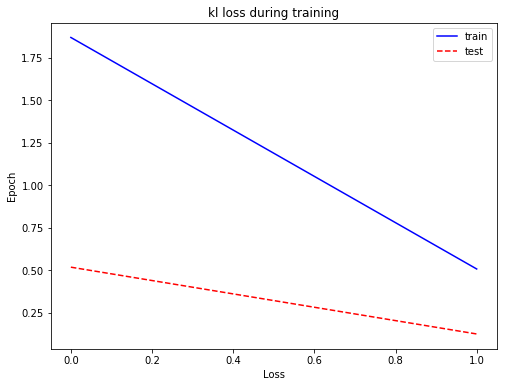

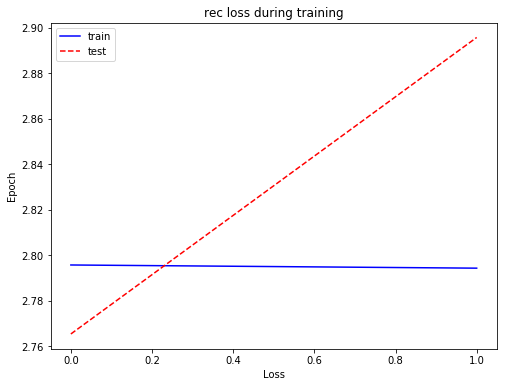

In [6]:
best_ckpt = feature_extractor.Train(train_gen, 
                                    test_gen, 
                                    "vae_no_activation_sigmod_recon_not_zero_centered",
                                    epochs=2, 
                                    sample_inf_gen=sample_gen)

In [8]:
ckpt = 'vae_no_activation_sigmod_recon_000/ep_17_loss_11.932.ckpt'
ckpt = 'vae_no_activation_sigmod_recon_not_zero_centered/ep_29_loss_3.007.ckpt'
#ckpt = 'auto_enc_000/ep_100_loss_7.743.ckpt'
#ckpt = 'vae_no_activation_func_000/ep_45_loss_11.641.ckpt'
test_gen.reset()
images, _ = test_gen.get_next_batch()
recons, ims = feature_extractor.Infer(images, best_ckpt, '.')

INFO:tensorflow:Restoring parameters from vae_no_activation_sigmod_recon_not_zero_centered/ep_29_loss_3.007.ckpt


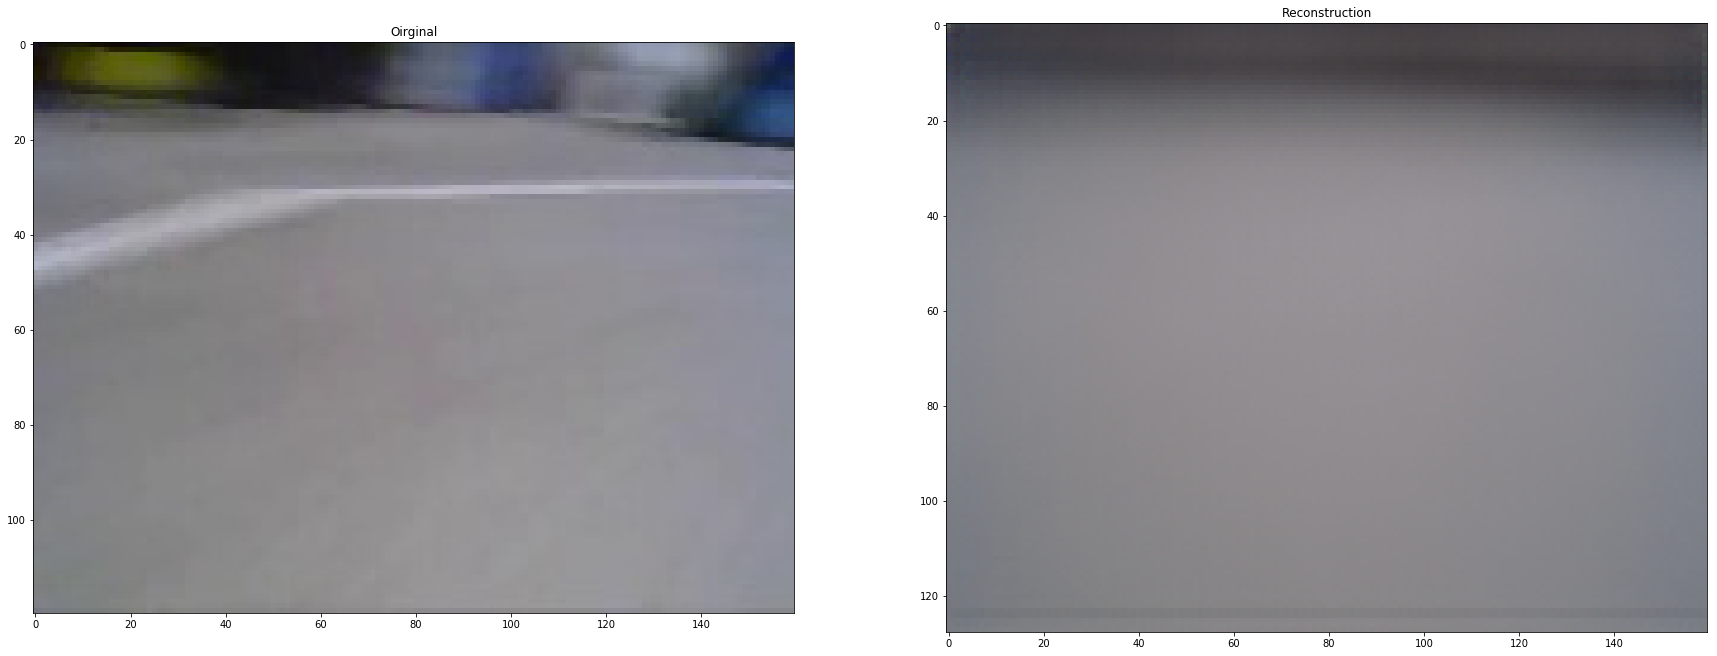

In [13]:
%matplotlib inline
idx = 4
plt.subplot(121)
plt.imshow(ims[idx])
fig = plt.gcf()
plt.title("Oirginal")

plt.subplot(122)
plt.imshow(recons[idx])
fig = plt.gcf()
plt.title("Reconstruction")
fig.set_size_inches(30, 15)


In [ ]:
from show_graph import show_graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=(None, 80,80,1), name="input")
y = tf.placeholder(tf.int32, shape=(None,), name="label")
training = tf.placeholder(tf.bool, name="training")

relu    = tf.nn.relu

with tf.name_scope("encoder"):
    #             in   num  conv   stride   pad
    enc = conv2d(  x , 24,  (5,5), (2,2),  "same", activation=relu, kernel_initializer=xavier(), name="enc1")
    enc = conv2d( enc, 32,  (5,5), (2,2),  "same", activation=relu, kernel_initializer=xavier(), name="enc2")
    enc = conv2d( enc, 64,  (5,5), (2,2),  "same", activation=relu, kernel_initializer=xavier(), name="enc3")
    enc = conv2d( enc, 64,  (3,3), (2,2),  "same", activation=relu, kernel_initializer=xavier(), name="enc4")
    enc = conv2d( enc, 64,  (3,3), (1,1),  "same", activation=relu, kernel_initializer=xavier(), name="enc5")
    enc = flatten(enc)
    #             in   num  
    enc = dense(  enc, 100, activation=relu, kernel_initializer=xavier(), name="enc6")
    enc = dropout(enc, rate=0.1, training=training)
    
    enc = dense(  enc, 50, activation=relu, kernel_initializer=xavier(), name="enc7")
    enc = dropout(enc, rate=drop, training=training)
    
    logits = dense(enc, 15, activation=None, kernel_initializer=xavier(), name="logits")
    steering = tf.nn.softmax(logits, name="steering")

with tf.name_scope("loss"):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="class_loss")
    loss = tf.reduce_mean(loss)
show_graph(tf.get_default_graph().as_graph_def())

### Load Data list names
Rather than load all the data into ram. We just load the names of all the images and annotations. Shuffle the names and partition them into train and test sets. Then we only load the images/annotations when neeed.

In [ ]:
base_dir      = '../data/gray_80_80_annotated/'
image_dir     = base_dir + 'images/'
anno_dir      = base_dir + 'annotations/'
train_path = '../data/evened_train.txt'
test_path  = '../data/evened_test.txt'

raw_train = load_data(train_path)
raw_test = load_data(test_path)

# Bin Steering Data
The steering and throttle annotations come in as numbers between 0 and 1023. So our network does not need to have 1024 output neurons we partition the data into bins.

ie:

if we had data consisting of numbers 0-9 :



`data = [1,4,5,0,9,8,5,4,3,2,5,6,7]`

and we binned in lost of 2 the our data would look like this:
```
# bins:  0   1   2   3   4
# nums: 01, 23, 45, 67, 89

binned = [0,2,2,0,4,4,2,2,1,1,2,3,3]
```

In [ ]:
NUM_BINS = 8
train = bin_steering_annos(raw_train, NUM_BINS)
test = bin_steering_annos(raw_test, NUM_BINS)
for i,a in train[100:110]:
    print(a)

## Data Generator

This is what we're going to use to take care of loading our actual images and annotations as we need them. When initalized it shuffles the `data_names` then calling the `get_next_bacth` function returns a tuple of `(images, annotations)`. Calling the `still_has_data`function returns a boolean indicating wether or not all the data has been used up.

In [ ]:
from data_generator import DataGenerator

In [ ]:
my_data=DataGenerator(batch_size=10, 
                      data_set=train,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)


Below we plot a histogram of the data we're going to use to train the model. Just to make sure there is not a crazy bias in the data.

*eg: if the video containing the data has the car parked for a few seconds at the beginning and end of a run you may get a large spike in the data around 'go strait'*

In [ ]:
annos = my_data._all_annotations()
print("anno check: min: {}, max: {}, mean: {}".format(np.min(annos), np.max(annos), np.mean(annos)))
plt.hist(annos)

In [ ]:
images, annos = my_data.get_next_batch()
print("anno check: min: {}, max: {}, mean: {}".format(np.min(annos), np.max(annos), np.mean(annos)))

for i, (im, an) in enumerate(zip(images[:10], annos[:10])):
    plot = i+1
    plt.subplot(2,5,plot)
#     print("shape: {}".format(np.shape(im[:,:,0])))
    plt.imshow(im[:,:,0])
    plt.axis('off')
    # Covert to +- 100% for hard left or hard right
    angle = an
    plt.title("bin:{}".format(int(angle)))


### Some hyperparams

In [ ]:
from show_graph import show_graph
from model import Model
car_vae = Model()
#show_graph(car_brain.GetGraph())
# show_graph(tf.get_default_graph().as_graph_def())

### Defining the model

In [ ]:
train_gen=DataGenerator(batch_size=50, 
                      data_set=train[:100],
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)

test_gen=DataGenerator(batch_size=50, 
                      data_set=test[:50],
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)

In [ ]:
epochs = 2
batch_size = 50
learning_rate = 0.001
car_brain.Train(train_gen=train_gen,
               test_gen=test_gen,
               epochs=epochs)



In [ ]:
tr_loss, te_loss, te_acc = car_brain.TrainingResults()
print(tr_loss)
print(te_loss)
plt.plot(te_loss)

### Function to encode a list of input images


In [ ]:
test_gen = DataGenerator(batch_size=10, 
                      data_set=test[:100],
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)
test_image, anno = test_gen.get_next_batch()
ckpt = "ep_2-step_1-loss_4.73.ckpt"
probs, preds = car_brain.Predict(test_image, ckpt)
pred_angles = car_brain.ExpectedBinToDeg(preds)

In [ ]:
bins = list(range(1,NUM_BINS+1))
y_pos = np.arange(8)
print("len: ", len(annos))
for i, (im, an, prob, pred) in enumerate(zip(images, annos, probs, preds)):
    plot = i + 1
    plt.subplot(2,10,plot)
    plt.xticks([])    
    plt.yticks([])
    plt.title("{}".format(int(an)))
    plt.imshow(im[:,:,0])
    
    plot += 10
    plt.subplot(2,10,plot)
    plt.bar(bins, pr)
    plt.axis([0, 9, 0, 1.])
    plt.yticks([],[])
    plt.title("{:.2}".format(pred))
    
plt.subplot(2,10,11)
plt.xlabel("Class")
plt.ylabel("Prob")
#plt.yticks([0.,0.2, 0.4, 0.6, 0.8, 1.0])

In [ ]:
all_img_paths = get_paths_glob(image_dir+"*.jpg")
all_images    = load_images(all_img_paths)

In [ ]:
tf.reset_default_graph()
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,'./ep_19-step_50-loss_0.5418351888656616.ckpt')
    for img_pth in all_img_paths:
        name = img_pth.split('/')[-1].split('.')[0]
        img  = load_image(img_pth)
#         img  = img[np.newaxis, :,:, np.newaxis]
        img = np.expand_dims(img, axis=0)
        img = np.expand_dims(img, axis=3)
        img = img.astype('float32')
        ang = sess.run([prediction],feed_dict={x: img,  training: False})
        with open("./to_make_movie.txt", 'a') as file:
            file.write("{}, {}\n".format(name, ang[0][0]))

In [ ]:
#print(all_img_paths[0].split('/')[-1].split('.')[0])
for a, img_pth in zip(angles, all_img_paths):
    im = img_pth.split('/')[-1].split('.')[0]
    with open("./to_make_movie.txt", 'a') as file:
        file.write("{}, {}\n".format(im, a[0:0]))

In [ ]:
from annotate_video_inplace import *
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,'./ep_19-step_50-loss_0.5418351888656616.ckpt')
    
    video_inference(sess, x, prediction, training, "/home/jp/Documents/FYP/ml/data/videoplayback.mp4", "/home/jp/Desktop/video_infer")

In [ ]:
os.path.exists("/home/jp/Documents/FYP/ml/data/videoplayback.mp4")

In [ ]:
from tqdm import trange
from random import random, randint
from time import sleep

t = trange(100)
for i in t:
    # Description will be displayed on the left
    t.set_description('GEN %i' % i)
    # Postfix will be displayed on the right, and will format automatically
    # based on argument's datatype
    t.set_postfix(loss=random(), gen=randint(1,999), str='h', lst=[1, 2])
    sleep(0.1)